In [136]:
!pip install xgboost
%reset
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from xgboost import XGBClassifier

from sklearn.metrics import f1_score
from sklearn.tree import plot_tree

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
pd.set_option('display.precision', 3)
pd.set_option('display.max_colwidth', None)

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Opdracht 1: Exploratieve Data Analyse:
Gemaakt door de Majestueuze data-jokers:

&nbsp;&nbsp;&nbsp;&nbsp;Mark "Markolie20" Olieman <br>
&nbsp;&nbsp;&nbsp;&nbsp;Daan "Daan Eising" Eising <br>
&nbsp;&nbsp;&nbsp;&nbsp;Jesse "zdfgdfsg" van der Westen <br>

In [148]:
class EDA:
    def __init__(self, cols):
        # Define feature and target columns
        self.feature_cols = cols.difference(["p_id", "Outcome"])
        self.target_col = "Outcome"
        
        # Define which columns need to have zero values removed and which columns to replace the values with a KNN model
        self.col_to_drop_rows = ['BMI', 'Glucose', 'BloodPressure']
        self.col_to_validate = ["Insulin", "SkinThickness"]
        
        # Define objects to use
        self.df_handler = DfHandler()
        self.vis = Visualizer()
        
    def analyze_data(self, df):
        # Update the feature columns to match the dataframe
        self.analyze_cols = df.columns.difference(["p_id", "Outcome"])
        
        # Display the first 5 rows of the dataset to get a feel for how it looks
        display(df.head(5))
        
        # Display several stats of the dataset
        self.df_handler.display_stats(df, self.analyze_cols)
        
        # Display plots to show how the data is distributed in the feature columns
        self.vis.box_dist_plots(df, self.analyze_cols)
        
        # Display the correlation between the feature columns and the target column
        self.vis.corr_heatmap(self.df_handler.get_corr(df, self.analyze_cols, self.target_col))
    
    def clean_data(self, df, standardise=False, is_test_set=False):
        self.feature_cols = df.columns.difference(["p_id", "Outcome"])
        # Remove zero values from the previously defined columns
        df = self.df_handler.validate_and_drop_rows(df, self.col_to_drop_rows, self.col_to_validate, is_test=is_test_set)
        if standardise:
            df = self.df_handler.standardise_df(df, self.feature_cols)
        return df
        
        

In [149]:
class Visualizer:
    def box_dist_plots(self, df, cols):
        # Create a useable figure with subplots
        fig, axes = plt.subplots(len(cols), 2, figsize=(10, 15))
        fig.tight_layout()   
        
        # Create boxplots and histograms for every feature column defined
        for index, col in enumerate(cols):
            sns.boxplot(x=df[col], ax=axes[index, 0])    
            sns.histplot(x=df[col], ax=axes[index, 1])
            
    def corr_heatmap(self, corr_df):
        # Create a 1D heatmap of the correlation between feature columns and the target column 
        fig = plt.figure(figsize=(5, 5))
        sns.heatmap(corr_df, annot=True)
        
    

In [150]:
class DfHandler:
    def display_stats(self, df, cols):
        # Display the count, mean, std, min, 25%, 50%, 75%, max and dtype of the given dataframe and columns
        stats = df[cols].describe().T
        stats['dtype'] = [df[col].dtype for col in cols]
        display(stats)
    
    
    def get_corr(self, df, feature_cols, target_col):
        corr = pd.DataFrame(df[feature_cols].corrwith(df[target_col], method='pearson'))
        corr = corr.sort_values(0, ascending=False)
        return corr
            
    def standardise_df(self, df, cols):
        scaler = StandardScaler()
        df[cols] = pd.DataFrame(scaler.fit_transform(df[cols]),
                                                     index=df[cols].index,
                                                     columns=df[cols].columns)
        return df
    
    def validate_and_drop_rows(self, df, drop_cols, invalid_cols, is_test=False):
        # Add '_valid' columns for columns with too many invalid values where '_valid' gives whether the row had a valid value
        for col in invalid_cols:
            name = col + '_valid'
            df[name] = np.where(df[col] == 0, 0, 1)
        if not is_test:
            for col in drop_cols:
                df = df[df[col] != 0]
        return df
    

In [151]:
df = pd.read_csv("train_c.csv")
eda = EDA(df.columns)

## Data bekijken
De eerste stap die wij volgen is het bekijken van de verdelingen van de data, dit doen we door de basisstatistieken van alle feature kolommen te bekijken. 
we bekijken volgende statistieken:
- Gemiddelde
- Mediaan
- Standaard deviatie
- Min- en Maximum
- Eerste en derde kwartiel


Ook plotten wij van elke feature kolom de boxplot en een histogram om te kijken hoe de waardes verdeeld zijn in de dataset. Hiermee kunnen wij zien of er data in de dataset zit die wellicht niet juist is of dat er wellicht een hoop uitschieters zijn. 
Ook kunnen we zien of de data normaal verdeeld is of niet en of er eigenaardigheden zijn.

Als laatst gaan wij ook alvast kijken welke correlaties er zijn tussen de feature kolommen en de target kolom, hiermee kunnen we alvast een beeld schetsen over hoe de feature kolommen de target kolom kunnen beschrijven.

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,668,6,98,58,33,190,34.0,0.430,43,0
1,324,2,112,75,32,0,35.7,0.148,21,0
2,624,2,108,64,0,0,30.8,0.158,21,0
3,690,8,107,80,0,0,24.6,0.856,34,0
4,473,7,136,90,0,0,29.9,0.210,50,0


,count,mean,std,min,25%,50%,75%,max,dtype
Age,614.0,33.265,11.851,21.000,24.000,29.000,41.000,72.00,int64
BMI,614.0,31.930,8.137,0.000,27.400,32.150,36.500,67.10,float64
BloodPressure,614.0,68.904,19.933,0.000,62.000,72.000,80.000,114.00,int64
DiabetesPedigreeFunction,614.0,0.468,0.329,0.078,0.238,0.365,0.629,2.42,float64
Glucose,614.0,120.466,31.960,0.000,99.000,115.000,140.000,197.00,int64
Insulin,614.0,81.251,116.947,0.000,0.000,27.000,130.000,744.00,int64
Pregnancies,614.0,3.809,3.376,0.000,1.000,3.000,6.000,15.00,int64
SkinThickness,614.0,20.456,16.063,0.000,0.000,23.000,32.000,99.00,int64


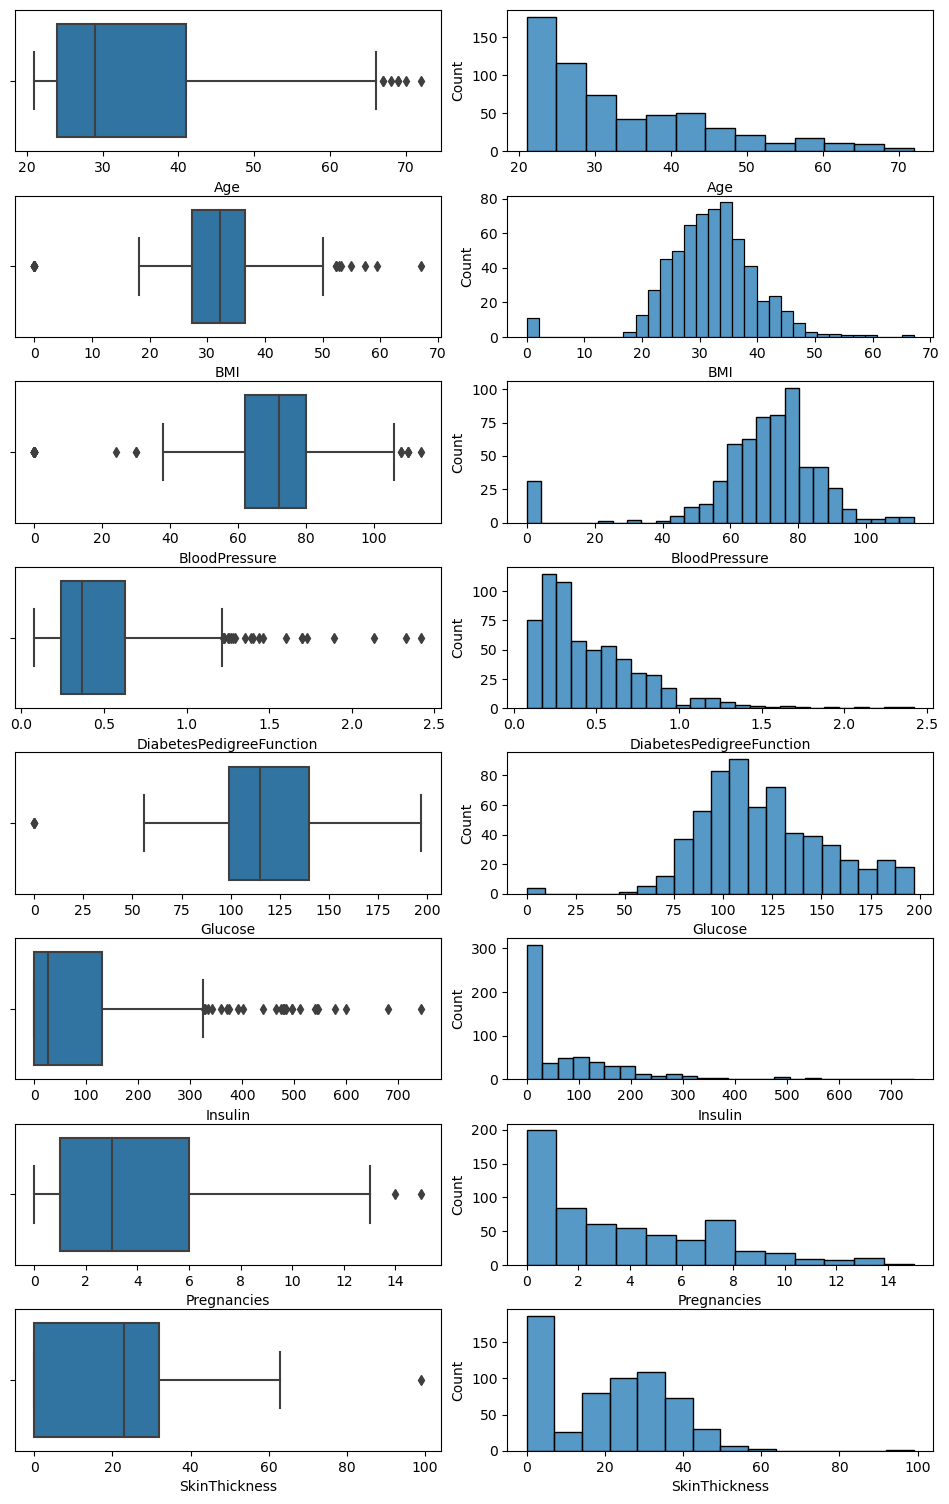

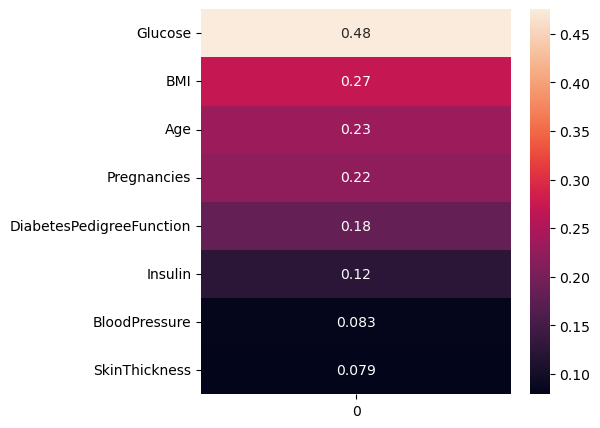

In [152]:
eda.analyze_data(df)

## Voldoet de data aan de voorwaarden voor machine learning?
De data voldoet aan de voorwaarden aangezien de data:
- In een dataframe staat
- Geen lege waardes bevat
- In numerieke waardes is beschreven

## Data opschonen
Echter vinden wij dat de data nog schoongemaakt kan worden, dit vinden wij omdat in de boxplots te zien valt dat de volgende kolommen nog waardes van 0 bevatten die niet mogelijk zouden moeten zijn.
- Glucose
- BMI
- BloodPressure
- Insulin
- SkinThickness

Deze waardes met 0 gaan wij uit de data verwijderen.

Ook zien we dat er veel uitschieters zijn, wij vinden het belangrijk om deze data alsnog mee te nemen aangezien wij denken dat dit wellicht komt door omstandigheden die ook kunnen bijdragen aan diabetes.

,p_id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,Insulin_valid,SkinThickness_valid
0,668,0.649,-0.768,-1.182,0.727,0.870,0.209,-0.124,0.814,0,1,1
1,324,-0.541,-0.312,0.198,0.664,-0.728,0.454,-0.980,-1.048,0,0,1
2,624,-0.541,-0.442,-0.695,-1.357,-0.728,-0.253,-0.950,-1.048,0,0,0
3,690,1.244,-0.475,0.605,-1.357,-0.728,-1.148,1.169,0.052,0,0,0
4,473,0.947,0.469,1.417,-1.357,-0.728,-0.383,-0.792,1.406,0,0,0


,count,mean,std,min,25%,50%,75%,max,dtype
Age,575.0,2.719e-16,1.001,-1.048,-0.794,-0.371,0.645,3.098,float64
BMI,575.0,-3.290e-16,1.001,-2.071,-0.715,-0.022,0.584,4.986,float64
BloodPressure,575.0,2.719e-16,1.001,-3.944,-0.695,-0.045,0.605,3.366,float64
DiabetesPedigreeFunction,575.0,1.406e-16,1.001,-1.193,-0.704,-0.303,0.500,5.917,float64
Glucose,575.0,1.452e-16,1.001,-2.135,-0.703,-0.182,0.665,2.455,float64
Insulin,575.0,-1.236e-17,1.001,-0.728,-0.728,-0.325,0.408,5.532,float64
Insulin_valid,575.0,5.426e-01,0.499,0.000,0.000,1.000,1.000,1.000,int32
Pregnancies,575.0,6.488e-17,1.001,-1.137,-0.839,-0.244,0.649,3.328,float64
SkinThickness,575.0,-1.081e-16,1.001,-1.357,-1.357,0.159,0.727,4.896,float64
SkinThickness_valid,575.0,7.339e-01,0.442,0.000,0.000,1.000,1.000,1.000,int32


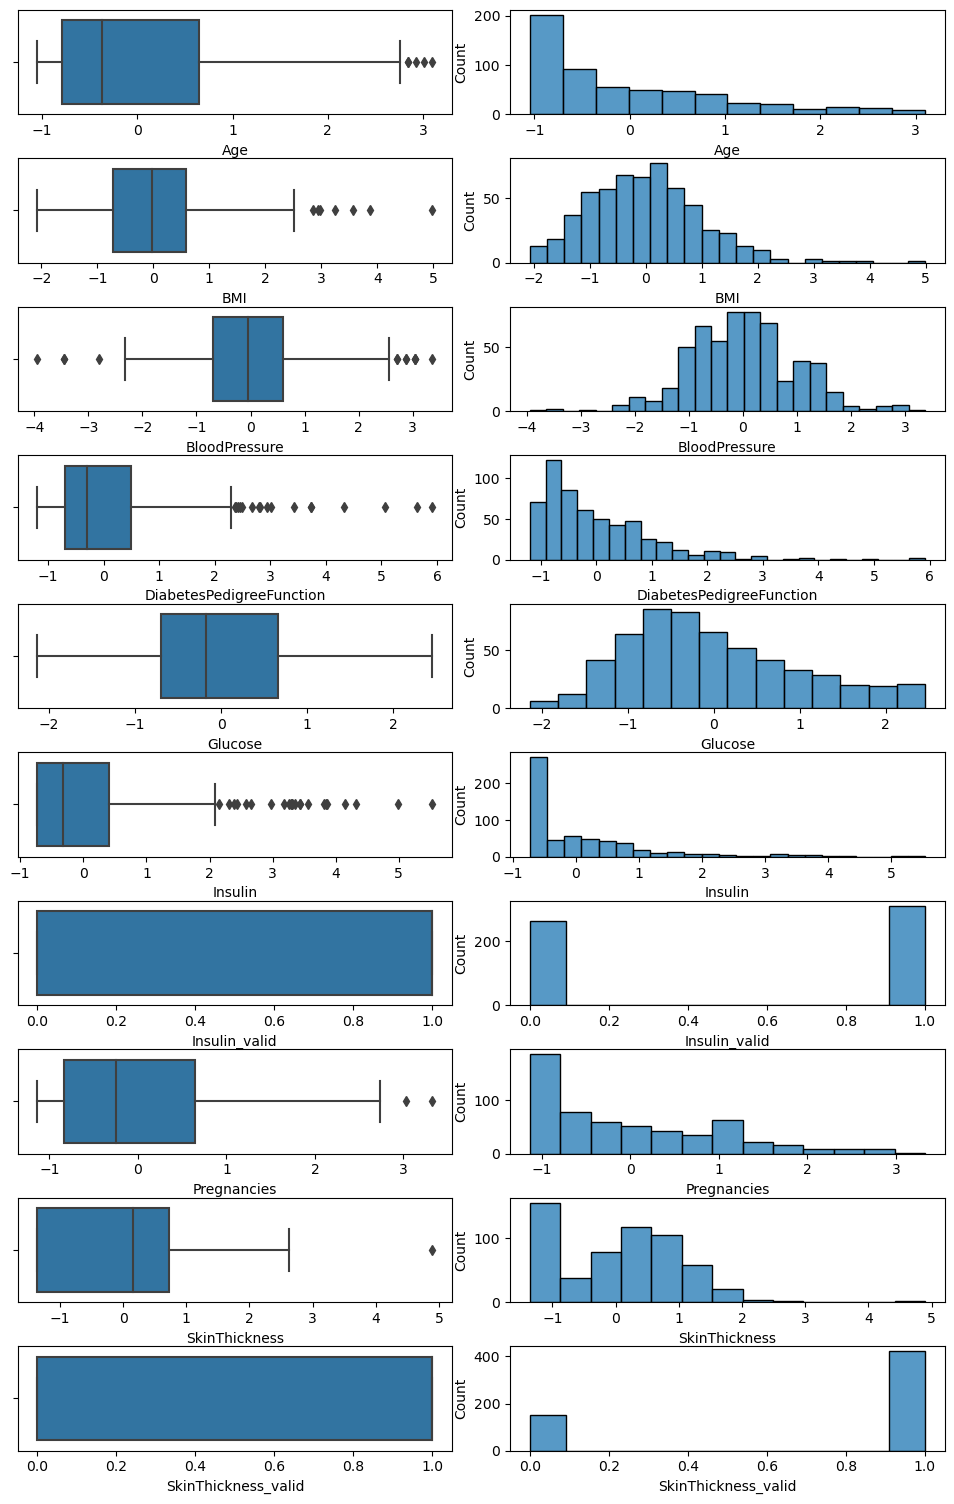

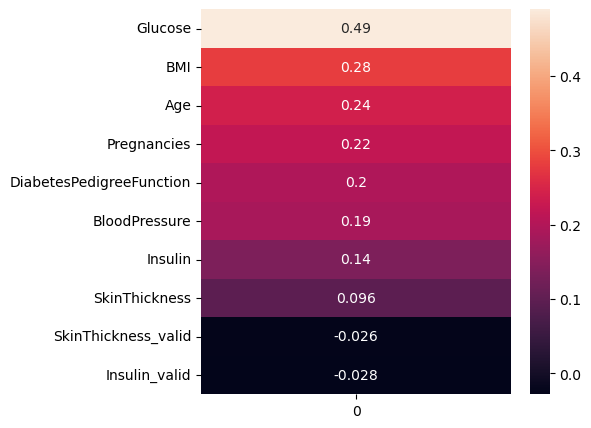

In [153]:
test_df = pd.read_csv('test_c.csv')
cleaned_df = eda.clean_data(df, standardise=True)
cleaned_test_df = eda.clean_data(test_df, standardise=True, is_test_set=True)
eda.analyze_data(cleaned_df)

## Opvallende dingen over opgeschoonde data
We zien dat de data van 614 rijen naar 312 rijen is gegaan, dit betekent dat wij een hoop rijen hebben verwijderd. Echter vinden wij dat dit beter is dan het alternatief, aangezien wij geen vertrouwen hebben goede modellen te kunnen maken als we geen goede data invoeren in de modellen. Zoals het beroemde gezegde "Garbage in = garbage out". 

We zien ook dat de correlaties omhoog zijn gegaan en dit is een goede indicatie dat de data die nu verwijderd is geen goede weergave gaf van de realiteit.

## Standaardiseren
Het staandaardiseren van data houdt in dat je de data schaalt op een manier dat het gemiddelde 0 wordt en de standaard deviatie 1. Om dit te doen wordt het aangeraden om data te hebben wat in een bell-curve valt en dat niet teveel outliers heeft. Ook is het alleen nuttig als feature kolommen ver uit elkaar liggen qua grootte van de waardes. Dit wordt gedaan om verschillende machine learning modellen beter te kunnen trainen als deze kijken naar afstand tussen datapunten om beslissingen te maken (zoals KNN of SVM).

Hoewel wij wel grote waardeverschillen hebben tussen de feature en KNN gebruiken om missende waardes in te vullen hebben wij toch besloten om niet de data te standaardiseren

In [157]:
class Machine_learner:
    def __init__(self, df, test_set):
        self.df_handler = DfHandler()
        
        self.df = df
        self.test_df = test_set
        
        self.pred = pd.DataFrame(self.test_df['p_id'])
        
        self.feature_cols = df.columns.difference(["p_id", "Outcome"])
        self.target_col = "Outcome"
        
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df[self.feature_cols],
                                                                                self.df[self.target_col],
                                                                                train_size = 0.2)
        
        
    def Lr(self):
        model = LogisticRegression()
        
        parameters = [{'solver' : ['newton-cg', 'lbfgs'],
                       'penalty' : ['l2'],
                       'max_iter' : [100, 150, 200, 500, 1000, 2500],
                       'C' : [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 1], 
                       'n_jobs': [-1]},
                      {'solver' : ['liblinear'],
                       'penalty' : ['l1', 'l2'],
                       'max_iter' : [100, 150, 200, 500, 1000, 2500],
                       'C' : [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.25, 0.5, 1]}]
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def decision_tree(self):
        model = DecisionTreeClassifier()
        
        parameters = {'criterion' : ['gini', 'entropy'],
                      'max_depth': range(3, 8),
                      'min_samples_split': [4, 5, 6],
                      'min_samples_leaf': [4, 5, 6]}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def random_forest(self):
        model = RandomForestClassifier()
        
        parameters = {'n_estimators': range(50, 100, 25),
                      'criterion': ['gini', 'entropy'],
                      'max_depth': range(2, 4),
                      'min_samples_split': [4, 5, 6],
                      'min_samples_leaf': [4, 5, 6],
                      'n_jobs': [-1]}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def gradient_boosting(self):
        model = GradientBoostingClassifier()
        
        parameters = {'n_estimators': range(5, 30, 5),
                      'learning_rate': np.arange(0.05, 0.15, 0.05),
                      'min_samples_split': [4, 5, 6],
                      'min_samples_leaf': [4, 5, 6]}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def ada_boosting(self):
        model = AdaBoostClassifier()
        
        parameters = {'n_estimators': range(10, 25, 5),
                      'learning_rate': np.arange(0.5, 1, 0.1)}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def svm(self):
        model = SVC()
        
        parameters = {
        'C': [0.1, 1, 10],
        'kernel': ['linear', 'rbf', 'poly'],
        'degree': [2, 3, 4],
        'coef0': [0.0, 0.1, 0.5],
        'shrinking': [True, False],
        'class_weight': [None, 'balanced'],
        'probability': [True, False],
        'tol': [1e-4, 1e-3, 1e-2],
        'max_iter': [100, 500, 1000], 
        }
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def xgboost(self):
        model = XGBClassifier()
        
        parameters = {'n_jobs': [-1],
                      'n_estimators': range(5, 30, 5),
                      'max_depth': range(2, 3),
                      'max_leaves': range(2, 4),
                      'learning_rate': np.arange(0.2, 0.4, 0.1),
                      'max_delta_step': np.arange(0.2, 0.4, 0.1),
                      'gamma': np.arange(0.2, 1, .1)}
        
        clf = GridSearchCV(model, parameters, verbose=1)
        return clf
    
    def fit(self, clf):
        clf.fit(self.X_train, self.y_train)
        
        train_y_pred = clf.predict(self.X_train)
        test_y_pred = clf.predict(self.X_test)
        f1_train = f1_score(self.y_train, train_y_pred)
        f1_test = f1_score(self.y_test, test_y_pred)
        
        relevant_score_cols = ['params','std_test_score', 'mean_test_score',  'rank_test_score']
        
        display(pd.DataFrame(clf.cv_results_)[relevant_score_cols].sort_values('rank_test_score').head(10))
        display(clf.best_estimator_)
        display(f1_train, f1_test)
        return clf
    
    def make_predictions(self, clf, name):
        self.pred['Outcome'] = clf.predict(test_df[self.feature_cols])
        self.pred.to_csv(name + '_prediction.csv', index=False)


In [158]:
ml = Machine_learner(cleaned_df, cleaned_test_df)
# ml.make_predictions(ml.fit(ml.Lr()), 'lr')
# ml.make_predictions(ml.fit(ml.decision_tree()), 'decision_tree')
# ml.make_predictions(ml.fit(ml.random_forest()), 'random_forest')
# ml.make_predictions(ml.fit(ml.gradient_boosting()), 'gradient_boost')
# ml.make_predictions(ml.fit(ml.ada_boosting()), 'ada_boost')
# ml.make_predictions(ml.fit(ml.svm()), 'svm')
ml.make_predictions(ml.fit(ml.xgboost()), 'XGboost')

Fitting 5 folds for each of 320 candidates, totalling 1600 fits


,params,std_test_score,mean_test_score,rank_test_score
139,"{'gamma': 0.5000000000000001, 'learning_rate': 0.2, 'max_delta_step': 0.30000000000000004, 'max_depth': 2, 'max_leaves': 3, 'n_estimators': 25, 'n_jobs': -1}",0.059,0.809,1
59,"{'gamma': 0.30000000000000004, 'learning_rate': 0.2, 'max_delta_step': 0.30000000000000004, 'max_depth': 2, 'max_leaves': 3, 'n_estimators': 25, 'n_jobs': -1}",0.059,0.809,1
19,"{'gamma': 0.2, 'learning_rate': 0.2, 'max_delta_step': 0.30000000000000004, 'max_depth': 2, 'max_leaves': 3, 'n_estimators': 25, 'n_jobs': -1}",0.059,0.809,1
99,"{'gamma': 0.4000000000000001, 'learning_rate': 0.2, 'max_delta_step': 0.30000000000000004, 'max_depth': 2, 'max_leaves': 3, 'n_estimators': 25, 'n_jobs': -1}",0.059,0.809,1
38,"{'gamma': 0.2, 'learning_rate': 0.30000000000000004, 'max_delta_step': 0.30000000000000004, 'max_depth': 2, 'max_leaves': 3, 'n_estimators': 20, 'n_jobs': -1}",0.059,0.809,1
313,"{'gamma': 0.9000000000000001, 'learning_rate': 0.30000000000000004, 'max_delta_step': 0.30000000000000004, 'max_depth': 2, 'max_leaves': 2, 'n_estimators': 20, 'n_jobs': -1}",0.052,0.800,6
73,"{'gamma': 0.30000000000000004, 'learning_rate': 0.30000000000000004, 'max_delta_step': 0.30000000000000004, 'max_depth': 2, 'max_leaves': 2, 'n_estimators': 20, 'n_jobs': -1}",0.052,0.800,6
113,"{'gamma': 0.4000000000000001, 'learning_rate': 0.30000000000000004, 'max_delta_step': 0.30000000000000004, 'max_depth': 2, 'max_leaves': 2, 'n_estimators': 20, 'n_jobs': -1}",0.052,0.800,6
273,"{'gamma': 0.8000000000000003, 'learning_rate': 0.30000000000000004, 'max_delta_step': 0.30000000000000004, 'max_depth': 2, 'max_leaves': 2, 'n_estimators': 20, 'n_jobs': -1}",0.052,0.800,6
33,"{'gamma': 0.2, 'learning_rate': 0.30000000000000004, 'max_delta_step': 0.30000000000000004, 'max_depth': 2, 'max_leaves': 2, 'n_estimators': 20, 'n_jobs': -1}",0.052,0.800,6


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=0.30000000000000004, max_depth=2, max_leaves=3,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=25, n_jobs=-1,
              num_parallel_tree=None, random_state=None, ...)

0.7083333333333334

0.49792531120331956